## Project3: 设计开发一个基于深度学习的交通标志识别分类器

步骤如下：
- 数据导入
- 数据集探索性分析
- 设计实现深度学习算法模型架构
- 测试模型推理能力

## Step 0: 数据导入

In [3]:
import pickle

def load_traffic_sign_data(training_file, testing_file):
    with open(training_file, mode='rb') as f:
        train = pickle.load(f)
    with open(testing_file, mode='rb') as f:
        test = pickle.load(f)
    return train, test

# Load pickled data
train, test = load_traffic_sign_data('../traffic_signs_data/train.p', '../traffic_signs_data/test.p')
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

## Step 1: 数据集探索性分析

''pickled'' 数据是4个键值对的字典类型:

- `'features'` 是一个4D阵列，包含交通标志图像的原始像素数据(num examples, width, height, channels).
- `'labels'` 是包含交通标志标签/类别id的二维数组。文件`signnames.csv`包含每个id的id->name的映射。
-  `'sizes'` 是一个包含元组(width, height)的列表，表示图像的原始宽度和高度。 
- `'coords'` 是一个包含元组（x1，y1，x2，y2）的列表，表示图像中符号周围边界框的坐标。
  **这些坐标假定为原始图像。pickle数据包含这些图像的大小调整版本（32×32）** 


In [4]:
import numpy as np

# Number of examples
n_train, n_test = X_train.shape[0], X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many classes?
n_classes = np.unique(y_train).shape[0]

print("Number of training examples =", n_train)
print("Number of testing examples  =", n_test)
print("Image data shape  =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples  = 12630
Image data shape  = (32, 32, 3)
Number of classes = 43


### 可视化分析交通标志数据集

- 首先可视化一些训练样例

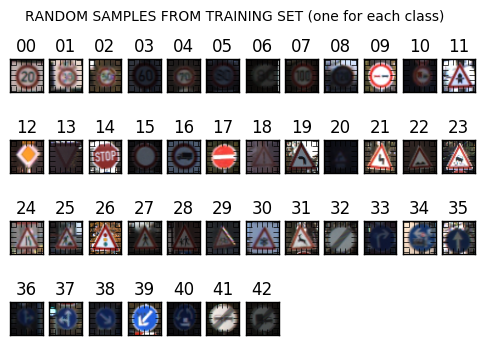

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

# show a random sample from each class of the traffic sign dataset
rows, cols = 4, 12
fig, ax_array = plt.subplots(rows, cols)
plt.suptitle('RANDOM SAMPLES FROM TRAINING SET (one for each class)')
for class_idx, ax in enumerate(ax_array.ravel()):
    if class_idx < n_classes:
        # show a random image of the current class
        cur_X = X_train[y_train == class_idx]
        cur_img = cur_X[np.random.randint(len(cur_X))]
        ax.imshow(cur_img)
        ax.set_title('{:02d}'.format(class_idx))
    else:
        ax.axis('off')
# hide both x and y ticks
plt.setp([a.get_xticklabels() for a in ax_array.ravel()], visible=False)
plt.setp([a.get_yticklabels() for a in ax_array.ravel()], visible=False)
plt.draw()

- 分析各类标志训练集和测试集中的分布

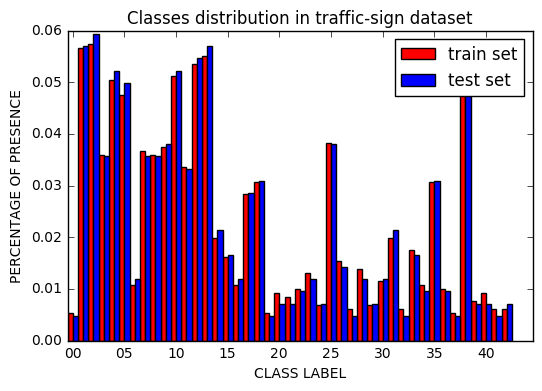

In [9]:
# bar-chart of classes distribution
train_distribution, test_distribution = np.zeros(n_classes), np.zeros(n_classes)
for c in range(n_classes):
    train_distribution[c] = np.sum(y_train == c) / n_train
    test_distribution[c] = np.sum(y_test == c) / n_test
fig, ax = plt.subplots()
col_width = 0.5
bar_train = ax.bar(np.arange(n_classes), train_distribution, width=col_width, color='r')
bar_test = ax.bar(np.arange(n_classes)+col_width, test_distribution, width=col_width, color='b')
ax.set_ylabel('PERCENTAGE OF PRESENCE')
ax.set_xlabel('CLASS LABEL')
ax.set_title('Classes distribution in traffic-sign dataset')
ax.set_xticks(np.arange(0, n_classes, 5)+col_width)
ax.set_xticklabels(['{:02d}'.format(c) for c in range(0, n_classes, 5)])
ax.legend((bar_train[0], bar_test[0]), ('train set', 'test set'))
plt.show()

从这个图中，我们注意到类之间存在着很强的不平衡性。事实上，一些类的代表性相对过高，而另一些类则不那么普遍。然而，我们看到训练集和测试集之间的数据分布几乎相同，这是一个好消息：当我们在测试数据上评估模型时，似乎不会出现与*数据集移位*相关的问题。

----

## Step 2: 设计实现深度学习模型架构

设计并实现一个学习识别交通标志的深度学习模型。在[德国交通标志数据集](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset)上训练和测试模型.

在思考这个问题时，有很多方面需要考虑： 

- 神经网络结构
- 数据预处理技术（标准化、rgb到灰度等）
- 每个标签的示例数（一些示例比其他示例多）
- 生成虚假数据


### 特征预处理

参考这篇论文[Sermanet，LeCun](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf)采用了特征预处理的三个主要步骤：
1） **每个图像都从RGB转换到YUV颜色空间，然后只使用Y通道**，这一选择乍一看可能令人惊讶，但引用的论文显示了这一选择如何产生最佳性能模型。这有点违反直觉，但如果我们仔细想想，我们可以通过查看灰度图像来区分所有的交通标志。
2） **通过直方图均衡化调整每个图像的对比度**。这是为了缓解众多图像对比度非常差的情况。
3） **每个图像以零均值为中心，并根据其标准偏差进行分割**。已知此功能缩放对优化器执行的梯度下降具有有利影响。

In [6]:
import cv2 

def preprocess_features(X, equalize_hist=True):

    # convert from RGB to YUV
    X = np.array([np.expand_dims(cv2.cvtColor(rgb_img, cv2.COLOR_RGB2YUV)[:, :, 0], 2) for rgb_img in X])

    # adjust image contrast
    if equalize_hist:
        X = np.array([np.expand_dims(cv2.equalizeHist(np.uint8(img)), 2) for img in X])

    X = np.float32(X)

    # standardize features
    X -= np.mean(X, axis=0)
    X /= (np.std(X, axis=0) + np.finfo('float32').eps)

    return X

X_train_norm = preprocess_features(X_train)
X_test_norm = preprocess_features(X_test)

### 数据集分割与数据增广

训练和测试数据集分割使用原始图片，分别由39209和12630个示例组成。

为了获得**附加数据**，可以用[Keras](https://keras.io/preprocessing/image/)提供的`ImageDataGenerator`类。没有必要重新发明轮子！通过这种方式，可以在训练期间在线执行数据扩充。为了在不完全扭曲原始特征内容的同时在数据中创建一些变化，训练图像被随机旋转、缩放和移动，但只是在一个狭窄的范围内。

Using TensorFlow backend.


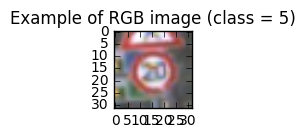

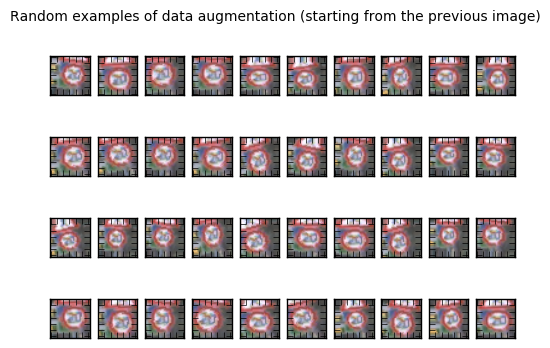

In [7]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

# split into train and validation
VAL_RATIO = 0.2
X_train_norm, X_val_norm, y_train, y_val = train_test_split(X_train_norm, y_train, test_size=VAL_RATIO, random_state=0)


# create the generator to perform online data augmentation
image_datagen = ImageDataGenerator(rotation_range=15.,
                                   zoom_range=0.2,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1)

# take a random image from the training set
img_rgb = X_train[0]

# plot the original image
plt.figure(figsize=(1,1))
plt.imshow(img_rgb)
plt.title('Example of RGB image (class = {})'.format(y_train[0]))
plt.show()

# plot some randomly augmented images
rows, cols = 4, 10
fig, ax_array = plt.subplots(rows, cols)
for ax in ax_array.ravel():
    augmented_img, _ = image_datagen.flow(np.expand_dims(img_rgb, 0), y_train[0:1]).next()
    ax.imshow(np.uint8(np.squeeze(augmented_img)))
plt.setp([a.get_xticklabels() for a in ax_array.ravel()], visible=False)
plt.setp([a.get_yticklabels() for a in ax_array.ravel()], visible=False)
plt.suptitle('Random examples of data augmentation (starting from the previous image)')
plt.show()

### 神经网络架构

参考[[Sermanet，LeCun]](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf)，最终的架构是由4层构成的相对较浅的网络。前两层是卷积层，而第三层和最后一层是全连接层。以下第一和第二卷积层的输出被串联并馈送到下一密集层。通过这种方式，我们在两个不同的抽象层次上提供了完全连接的层视觉模式。最后一个完全连接的层将预测映射到43个类中的一个。

In [8]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten


def weight_variable(shape, mu=0, sigma=0.1):
    initialization = tf.truncated_normal(shape=shape, mean=mu, stddev=sigma)
    return tf.Variable(initialization)


def bias_variable(shape, start_val=0.1):
    initialization = tf.constant(start_val, shape=shape)
    return tf.Variable(initialization)


def conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME'):
    return tf.nn.conv2d(input=x, filter=W, strides=strides, padding=padding)


def max_pool_2x2(x):
    return tf.nn.max_pool(value=x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')


# network architecture definition
def my_net(x, n_classes):

    c1_out = 64
    conv1_W = weight_variable(shape=(3, 3, 1, c1_out))
    conv1_b = bias_variable(shape=(c1_out,))
    conv1 = tf.nn.relu(conv2d(x, conv1_W) + conv1_b)

    pool1 = max_pool_2x2(conv1)

    drop1 = tf.nn.dropout(pool1, keep_prob=keep_prob)

    c2_out = 128
    conv2_W = weight_variable(shape=(3, 3, c1_out, c2_out))
    conv2_b = bias_variable(shape=(c2_out,))
    conv2 = tf.nn.relu(conv2d(drop1, conv2_W) + conv2_b)

    pool2 = max_pool_2x2(conv2)

    drop2 = tf.nn.dropout(pool2, keep_prob=keep_prob)

    fc0 = tf.concat(1, [flatten(drop1), flatten(drop2)])

    fc1_out = 64
    fc1_W = weight_variable(shape=(fc0._shape[1].value, fc1_out))
    fc1_b = bias_variable(shape=(fc1_out,))
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b

    drop_fc1 = tf.nn.dropout(fc1, keep_prob=keep_prob)

    fc2_out = n_classes
    fc2_W = weight_variable(shape=(drop_fc1._shape[1].value, fc2_out))
    fc2_b = bias_variable(shape=(fc2_out,))
    logits = tf.matmul(drop_fc1, fc2_W) + fc2_b

    return logits


# placeholders
x = tf.placeholder(dtype=tf.float32, shape=(None, 32, 32, 1))
y = tf.placeholder(dtype=tf.int32, shape=None)
keep_prob = tf.placeholder(tf.float32)


# training pipeline
lr = 0.001
logits = my_net(x, n_classes=n_classes)
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
loss_function = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train_step = optimizer.minimize(loss=loss_function)

### 训练参数

对于训练，可以使用**Adam optimizer**，这通常被证明是一个很好的选择，可以避免搜索SGD的正确参数。由于内存限制，**Batchsize**设置为128。每访问5000批，对训练和验证集进行评估。为了避免过度拟合，数据增加和丢失（丢失概率为0.5）都被广泛采用。

In [9]:
# metrics and functions for model evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.cast(y, tf.int64))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    
    num_examples = X_data.shape[0]
    total_accuracy = 0
    
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCHSIZE):
        batch_x, batch_y = X_data[offset:offset+BATCHSIZE], y_data[offset:offset+BATCHSIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += accuracy * len(batch_x)
        
    return total_accuracy / num_examples

# create a checkpointer to log the weights during training
checkpointer = tf.train.Saver()

In [11]:
# training hyperparameters
BATCHSIZE = 128
EPOCHS = 30
BATCHES_PER_EPOCH = 5000

In [8]:
# start training
with tf.Session() as sess:

    sess.run(tf.global_variables_initializer())

    for epoch in range(EPOCHS):

        print("EPOCH {} ...".format(epoch + 1))

        batch_counter = 0
        for batch_x, batch_y in image_datagen.flow(X_train_norm, y_train, batch_size=BATCHSIZE):

            batch_counter += 1
            sess.run(train_step, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})

            if batch_counter == BATCHES_PER_EPOCH:
                break

        # at epoch end, evaluate accuracy on both training and validation set
        train_accuracy = evaluate(X_train_norm, y_train)
        val_accuracy = evaluate(X_val_norm, y_val)
        print('Train Accuracy = {:.3f} - Validation Accuracy: {:.3f}'.format(train_accuracy, val_accuracy))
        
        # log current weights
        checkpointer.save(sess, save_path='../checkpoints/traffic_sign_model.ckpt', global_step=epoch)

EPOCH 1 ...
Train Accuracy = 0.889 - Validation Accuracy: 0.890
EPOCH 2 ...
Train Accuracy = 0.960 - Validation Accuracy: 0.955
EPOCH 3 ...
Train Accuracy = 0.975 - Validation Accuracy: 0.969
EPOCH 4 ...
Train Accuracy = 0.985 - Validation Accuracy: 0.977
EPOCH 5 ...
Train Accuracy = 0.987 - Validation Accuracy: 0.978
EPOCH 6 ...
Train Accuracy = 0.991 - Validation Accuracy: 0.985
EPOCH 7 ...
Train Accuracy = 0.991 - Validation Accuracy: 0.984
EPOCH 8 ...
Train Accuracy = 0.991 - Validation Accuracy: 0.985
EPOCH 9 ...
Train Accuracy = 0.991 - Validation Accuracy: 0.985
EPOCH 10 ...
Train Accuracy = 0.994 - Validation Accuracy: 0.988
EPOCH 11 ...
Train Accuracy = 0.996 - Validation Accuracy: 0.990
EPOCH 12 ...
Train Accuracy = 0.995 - Validation Accuracy: 0.989
EPOCH 13 ...
Train Accuracy = 0.995 - Validation Accuracy: 0.991
EPOCH 14 ...
Train Accuracy = 0.993 - Validation Accuracy: 0.988
EPOCH 15 ...
Train Accuracy = 0.995 - Validation Accuracy: 0.989
EPOCH 16 ...
Train Accuracy = 0.99

现在我们可以测试模型了。让我们在验证集上加载精度最高的历元权重，这是最有希望的：-）

In [12]:
# testing the model
with tf.Session() as sess:

    # restore saved session with highest validation accuracy
    checkpointer.restore(sess, '../checkpoints/traffic_sign_model.ckpt-27')
    
    test_accuracy = evaluate(X_test_norm, y_test)
    print('Performance on test set: {:.3f}'.format(test_accuracy))


Performance on test set: 0.953


---

## Step 3：在新图像上测试模型

拍摄几张你在网络上或你周围发现的交通标志的照片（至少五张），并在你的计算机上通过分类器运行它们以生成示例结果。分类器可能无法识别某些局部符号，但它可能会被证明是有趣的。

可能会发现`signnames.csv`很有用，因为它包含从类id（整数）到实际符号名的映射。

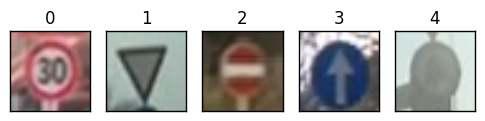

In [43]:
### Load the images and plot them here.
import os

# load new images
new_images_dir = '../other_signs'
new_test_images = [os.path.join(new_images_dir, f) for f in os.listdir(new_images_dir)]
new_test_images = [cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB) for f in new_test_images]

# manually annotated labels for these new images
new_targets = [1, 13, 17, 35, 40]

# plot new test images
fig, axarray = plt.subplots(1, len(new_test_images))
for i, ax in enumerate(axarray.ravel()):
    ax.imshow(new_test_images[i])
    ax.set_title('{}'.format(i))
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.set_xticks([]), ax.set_yticks([])


让我们在这些简单的新图像上测试经过训练的模型：

In [80]:
# first things first: feature preprocessing
new_test_images_norm = preprocess_features(new_test_images)

with tf.Session() as sess:

    # restore saved session
    checkpointer.restore(sess, '../checkpoints/traffic_sign_model.ckpt-27')

    # predict on unseen images
    prediction = np.argmax(np.array(sess.run(logits, feed_dict={x: new_test_images_norm, keep_prob: 1.})), axis=1)

for i, pred in enumerate(prediction):
    print('Image {} - Target = {:02d}, Predicted = {:02d}'.format(i, new_targets[i], pred))
    
print('> Model accuracy: {:.02f}'.format(np.sum(new_targets==prediction)/len(new_targets)))

Image 0 - Target = 01, Predicted = 01
Image 1 - Target = 13, Predicted = 13
Image 2 - Target = 17, Predicted = 02
Image 3 - Target = 35, Predicted = 35
Image 4 - Target = 40, Predicted = 40
> Model accuracy: 0.80


可视化softmax分数可以让我们更好地了解分类过程。

Top 3 model predictions for image 0 (Target is 01)
   Prediction = 01 with confidence 0.99
   Prediction = 02 with confidence 0.01
   Prediction = 05 with confidence 0.00
Top 3 model predictions for image 1 (Target is 13)
   Prediction = 13 with confidence 0.99
   Prediction = 38 with confidence 0.00
   Prediction = 12 with confidence 0.00
Top 3 model predictions for image 2 (Target is 17)
   Prediction = 02 with confidence 0.31
   Prediction = 38 with confidence 0.27
   Prediction = 17 with confidence 0.22
Top 3 model predictions for image 3 (Target is 35)
   Prediction = 35 with confidence 0.34
   Prediction = 03 with confidence 0.30
   Prediction = 08 with confidence 0.13
Top 3 model predictions for image 4 (Target is 40)
   Prediction = 40 with confidence 0.44
   Prediction = 12 with confidence 0.39
   Prediction = 38 with confidence 0.11


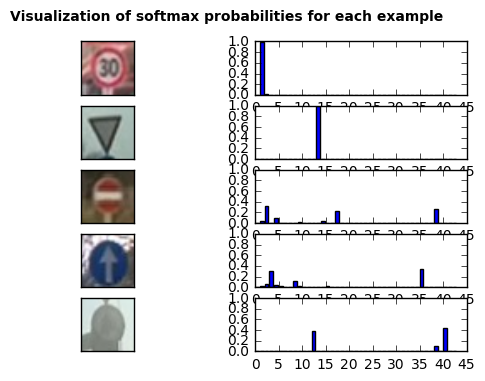

In [79]:
# visualizing softmax probabilities
with tf.Session() as sess:

    # restore saved session
    checkpointer.restore(sess, '../checkpoints/traffic_sign_model.ckpt-27')

    # certainty of predictions
    K = 3
    top_3 = sess.run(tf.nn.top_k(logits, k=K), feed_dict={x: new_test_images_norm, keep_prob: 1.})

    # compute softmax probabilities
    softmax_probs = sess.run(tf.nn.softmax(logits), feed_dict={x: new_test_images_norm, keep_prob: 1.})

# plot softmax probs along with traffic sign examples
n_images = new_test_images_norm.shape[0]
fig, axarray = plt.subplots(n_images, 2)
plt.suptitle('Visualization of softmax probabilities for each example', fontweight='bold')
for r in range(0, n_images):
    axarray[r, 0].imshow(np.squeeze(new_test_images[r]))
    axarray[r, 0].set_xticks([]), axarray[r, 0].set_yticks([])
    plt.setp(axarray[r, 0].get_xticklabels(), visible=False)
    plt.setp(axarray[r, 0].get_yticklabels(), visible=False)
    axarray[r, 1].bar(np.arange(n_classes), softmax_probs[r])
    axarray[r, 1].set_ylim([0, 1])
    
# print top K predictions of the model for each example, along with confidence (softmax score)    
for i in range(len(new_test_images)):
    print('Top {} model predictions for image {} (Target is {:02d})'.format(K, i, new_targets[i]))
    for k in range(K):
        top_c = top_3[1][i][k]
        print('   Prediction = {:02d} with confidence {:.2f}'.format(top_c, softmax_probs[i][top_c]))


从上面的图中可以看出，我们的模型非常确定前两个交通标志属于哪一类，但对其他三个交通标志有点混淆。事实上，在前两种情况下，模型不仅能够预测正确的类别，而且显示出很高的可信度。对于第三个例子（无进入标志），模型的预测是错误的，尽管正确的目标出现在前三个预测中，这是令人鼓舞的。最后，最后两个例子是正确预测的：即使是最后一个（环岛强制），如果我们相信自己的眼睛，这是相当困难的！然而，softmax的分布并不存在：对于最后两张图像，模型并不确定哪张是正确的标签。